In [1]:
import os
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
OUT_DIR = "/content/flight_optuna_best"
os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
# Risk base rates by weather
risk_base = {
    'clear': 0.1,
    'light_rain': 0.2,
    'fog': 0.25,
    'heavy_turbulence': 0.6,
    'storm': 0.7
}

# Maintenance multipliers
maint_multiplier = {
    0: 0.5,   # good maintenance
    1: 1.0,   # moderate
    2: 1.5    # poor
}

In [3]:
def sample_incident(weather, maintenance):
    """Sample incident label based on weather and maintenance."""
    p = risk_base[weather] * maint_multiplier[maintenance]
    return np.random.rand() < min(p, 0.99)

In [4]:
def generate_realistic_sequence(is_incident, timesteps=60):
    """Generate a telemetry sequence with optional incident effects."""
    t = np.linspace(0, 1, timesteps)
    phase = random.choice(['takeoff','cruise','landing','climb','descent'])
    weather_severity = np.random.uniform(0,1)

    # Base altitude profile
    if phase == 'takeoff':
        alt_base = 1000 + 8000*t; crit = slice(0,15)
    elif phase == 'landing':
        alt_base = 9000 - 8000*t; crit = slice(45,60)
    elif phase == 'cruise':
        alt_base = 35000 + 1000*np.sin(2*np.pi*t*0.3); crit = slice(20,40)
    elif phase == 'climb':
        alt_base = 10000 + 15000*t; crit = slice(15,45)
    else:  # descent
        alt_base = 25000 - 15000*t; crit = slice(15,45)

    altitude = alt_base + weather_severity * np.random.normal(0,500,timesteps)
    alt_diff = np.gradient(altitude)
    speed = 250 + 200*(altitude/40000) - 0.1*alt_diff + np.random.normal(0,20,timesteps)
    pitch = np.arctan(alt_diff/1000) + np.random.normal(0,0.02,timesteps)
    roll  = np.random.normal(0,0.05,timesteps)
    yaw   = np.random.normal(0,0.03,timesteps)
    thrust  = 80 + 20*(speed/450) + np.random.normal(0,5,timesteps)
    engine_temp = 200 + (thrust- np.random.normal(0,5,timesteps))*2 + weather_severity*50
    engine_temp += np.random.normal(0,10,timesteps)

    # Incident effects
    if is_incident:
        window = max(1, crit.stop - crit.start - 10)
        start = crit.start + random.randint(0, window)
        rem = timesteps - start
        length = min(20, rem)
        typ = random.choice(['engine_failure','severe_weather','system_malfunction'])

        if typ == 'engine_failure':
            m_len = min(15, rem); m = slice(start, start+m_len)
            thrust[m] *= 0.3
            altitude[m] -= np.cumsum(np.ones(m_len)*100)
            speed[m] *= 0.8
            pitch[m] -= 0.15

        elif typ == 'severe_weather':
            m = slice(start, start+length)
            altitude[m] += np.random.normal(0,800,length)
            speed[m]    += np.random.normal(0,50,length)
            pitch[m]    += np.random.normal(0,0.1,length)
            roll[m]     += np.random.normal(0,0.15,length)

        else:  # system_malfunction
            m = slice(start, timesteps)
            t_sub = t[m]
            pitch[m] += 0.05*np.sin(4*np.pi*t_sub)
            roll[m]  += 0.08*np.cos(6*np.pi*t_sub)

    # Stack features
    seq = np.vstack([altitude, speed, pitch, roll, yaw, thrust, engine_temp]).T
    return seq, phase, weather_severity

In [5]:
def add_realistic_noise_and_artifacts(seqs, noise_level=0.02):
    """Add sensor noise and occasional dropouts to sequences."""
    noisy = seqs.copy()
    N, T, F = noisy.shape
    for i in range(N):
        for f in range(F):
            std = np.std(noisy[i,:,f])
            scale = noise_level * (std if f in [0,1] else 0.5*std)
            noise = np.random.normal(0, scale, T)
            noisy[i,:,f] += noise
            if np.random.rand() < 0.05:
                idx = np.random.randint(1, T-1)
                noisy[i,idx,f] = noisy[i,idx-1,f]
    return noisy


In [6]:
from tqdm import tqdm
import pandas as pd

def create_balanced_dataset(n_samples=8000, seq_len=60):
    """Generate a dataset with a 50/50 split of non-incidents and incidents."""
    half = n_samples // 2
    sequences, metadata, labels = [], [], []
    
    # First generate non-incidents
    for _ in tqdm(range(half), desc="Generating non-incidents"):
        # Always generate is_incident=False
        seq, phase, ws = generate_realistic_sequence(False, seq_len)
        # Derive metadata exactly as before
        if ws < 0.3:
            weather = 'clear'
        elif ws < 0.6:
            weather = random.choice(['light_rain','fog'])
        else:
            weather = random.choice(['heavy_turbulence','storm'])
        maintenance = np.random.choice([0,1,2], p=[0.6,0.3,0.1])
        # Regenerate sequence to keep consistency
        seq, phase, ws = generate_realistic_sequence(False, seq_len)
        # Add noise/artifacts
        seq = add_realistic_noise_and_artifacts(seq[np.newaxis], noise_level=0.02)[0]
        sequences.append(seq)
        metadata.append([weather, phase, maintenance])
        labels.append(0)
    
    # Then generate incidents
    for _ in tqdm(range(half), desc="Generating incidents"):
        seq, phase, ws = generate_realistic_sequence(True, seq_len)
        if ws < 0.3:
            weather = 'clear'
        elif ws < 0.6:
            weather = random.choice(['light_rain','fog'])
        else:
            weather = random.choice(['heavy_turbulence','storm'])
        maintenance = np.random.choice([0,1,2], p=[0.6,0.3,0.1])
        seq, phase, ws = generate_realistic_sequence(True, seq_len)
        seq = add_realistic_noise_and_artifacts(seq[np.newaxis], noise_level=0.02)[0]
        sequences.append(seq)
        metadata.append([weather, phase, maintenance])
        labels.append(1)
    
    # Convert to arrays/DataFrame
    sequences = np.array(sequences)
    metadata_df = pd.DataFrame(metadata, columns=['weather','phase','maintenance'])
    labels = np.array(labels)
    
    # Shuffle the dataset to mix incidents and non-incidents
    perm = np.random.permutation(n_samples)
    return sequences[perm], metadata_df.iloc[perm].reset_index(drop=True), labels[perm]


In [7]:
sequences, metadata_df, labels = create_balanced_dataset(n_samples=10000, seq_len=60)

Generating incidents: 100%|██████████| 5000/5000 [00:03<00:00, 1297.21it/s]


In [8]:
print(np.isnan(sequences).sum(), "NaNs in sequences")
# print(np.isnan(metadata_df.values).sum(), "NaNs in metadata")
print(np.isnan(labels).sum(), "NaNs in labels")

0 NaNs in sequences
0 NaNs in labels


In [9]:
sequences[1]

array([[ 3.49854903e+04,  4.07414755e+02,  6.05138360e-03,
        -9.51047728e-03, -6.99961378e-03,  1.03246241e+02,
         4.07183994e+02],
       [ 3.50559795e+04,  3.91703076e+02,  5.70538726e-02,
        -4.02613988e-02,  4.48244424e-02,  9.89410403e+01,
         3.89582049e+02],
       [ 3.50527545e+04,  3.94385950e+02, -8.19244865e-03,
         7.52059016e-02, -8.85101359e-03,  9.62012845e+01,
         3.65879382e+02],
       [ 3.50748145e+04,  4.42902936e+02, -1.16863160e-02,
        -1.83886460e-02,  3.14163205e-02,  9.70315134e+01,
         3.99158838e+02],
       [ 3.50926483e+04,  4.46238771e+02,  4.94843121e-02,
        -1.08750674e-02, -2.87019036e-03,  9.83959612e+01,
         3.99515448e+02],
       [ 3.51234809e+04,  4.21398815e+02,  1.08624833e-02,
        -5.20551858e-02,  3.74498917e-02,  9.31538915e+01,
         3.83662466e+02],
       [ 3.51768823e+04,  4.03457154e+02,  6.04479594e-02,
        -9.80744938e-03,  3.25842506e-02,  9.88704384e+01,
         4.0855292

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [33]:
def train_epoch(
    model,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    accumulation_steps=4,
    max_grad_norm=0.5,
    optimum_threshold=0.4794
):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad(set_to_none=True)

    for i, (sequences, metadata, labels) in enumerate(dataloader):
        sequences = sequences.to(device).float()         # (batch, seq_len, num_features)
        metadata = metadata.to(device).float()           # (batch, num_meta_features)
        labels = labels.to(device).float().unsqueeze(1)  # (batch, 1)

        # Forward pass
        outputs = model(sequences, metadata)             # (batch, 1)
        loss = criterion(outputs, labels)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # Gradient step every accumulation_steps batches
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        # Logging
        total_loss += loss.item() * accumulation_steps

        # Compute accuracy (binary classification)
        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            preds = (probs > optimum_threshold).float()  # Apply optimal threshold
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Handle last batch gradients if dataset size not divisible by accumulation_steps
    if (i + 1) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [34]:
def validate(model, dataloader, criterion, device, optimum_threshold=0.4794):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_probs = []
    all_labels = []

    with torch.inference_mode():
        for sequences, metadata, labels in dataloader:
            sequences = sequences.to(device).float()
            metadata = metadata.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(sequences, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            predictions = (probs > optimum_threshold).float()

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(probs.cpu().numpy().flatten().tolist())
            all_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy, np.array(all_probs), np.array(all_labels)


In [13]:
sequences.shape

(10000, 60, 7)

In [14]:
N, T, F = sequences.shape
print(f"Data shape: {N} samples, {T} timesteps, {F} features")

Data shape: 10000 samples, 60 timesteps, 7 features


In [15]:
# --- CLIPPING OUTLIERS (optional but recommended) ---
# These values can be customized based on domain knowledge; below are broad, reasonable ranges.
clip_mins = np.array([0,     150,  -1.0, -0.2, -0.1,   0,    300])   # altitude, speed, pitch, roll, yaw, thrust, engine_temp
clip_maxs = np.array([40000, 500,   1.0,  0.2,  0.1,  150,   500])   # adjust per feature range
sequences_clipped = np.clip(sequences, clip_mins, clip_maxs)

In [16]:
# --- NORMALIZE TELEMETRY FEATURES ---
from sklearn.preprocessing import MinMaxScaler

seq_flat = sequences_clipped.reshape(-1, F)
scaler = MinMaxScaler()
seq_flat_norm = scaler.fit_transform(seq_flat)
sequences_norm = seq_flat_norm.reshape(N, T, F)

In [17]:
print(np.isnan(sequences).sum(), "NaNs in sequences")
# print(np.isnan(metadata_df.values).sum(), "NaNs in metadata")
print(np.isnan(labels).sum(), "NaNs in labels")

0 NaNs in sequences
0 NaNs in labels


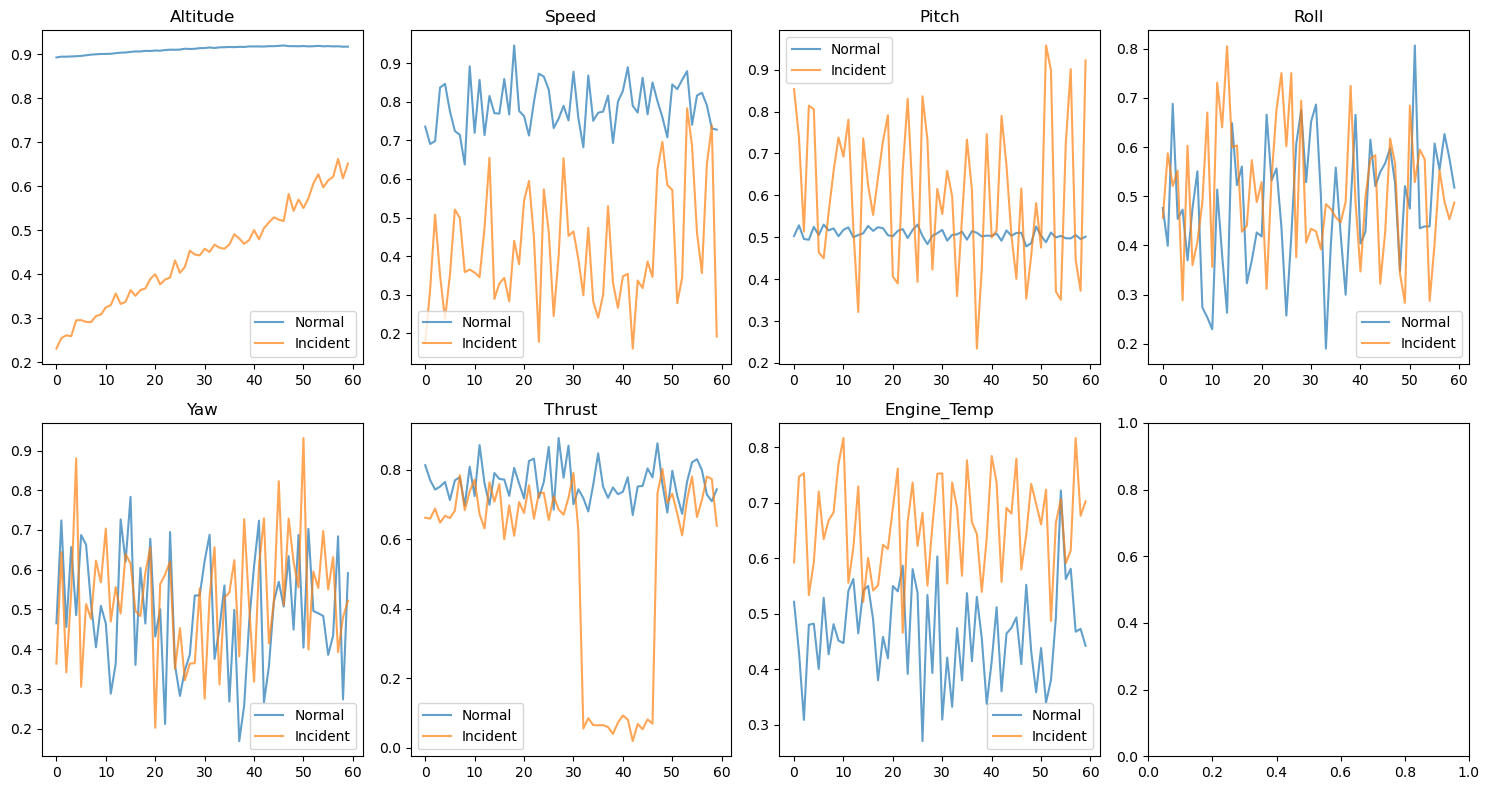

Metadata Distribution:
weather           maintenance
clear             0              1780
                  1               923
                  2               339
fog               0               859
                  1               446
                  2               146
heavy_turbulence  0              1223
                  1               593
                  2               215
light_rain        0               877
                  1               467
                  2               155
storm             0              1187
                  1               589
                  2               201
Name: count, dtype: int64

Incident rate by weather: weather
clear               1524
heavy_turbulence    1052
storm                945
light_rain           747
fog                  732
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt

def visualize_dataset_quality(sequences, labels, metadata_df):
    """Validate dataset quality"""
    
    # Plot sample sequences
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    feature_names = ['Altitude', 'Speed', 'Pitch', 'Roll', 'Yaw', 'Thrust', 'Engine_Temp']
    
    incident_idx = np.where(labels == 1)[0][0]
    normal_idx = np.where(labels == 0)[0][0]
    
    for i, feature_name in enumerate(feature_names):
        if i < 7:
            row, col = i // 4, i % 4
            axes[row, col].plot(sequences[normal_idx, :, i], label='Normal', alpha=0.7)
            axes[row, col].plot(sequences[incident_idx, :, i], label='Incident', alpha=0.7)
            axes[row, col].set_title(f'{feature_name}')
            axes[row, col].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Check metadata correlations
    print("Metadata Distribution:")
    print(metadata_df.groupby('weather')['maintenance'].value_counts())
    
    # Check class balance by conditions
    weather_incident_rate = metadata_df[labels == 1]['weather'].value_counts()
    print(f"\nIncident rate by weather: {weather_incident_rate}")

# Validate the dataset
visualize_dataset_quality(sequences_norm, labels, metadata_df)


In [19]:
# Preprocess metadata
cat_cols = ["weather", "phase"]
num_cols = ["maintenance"]

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

In [21]:
X_meta_processed = preprocessor.fit_transform(metadata_df)

# Convert sparse to dense if necessary
if hasattr(X_meta_processed, "toarray"):
    X_meta_processed = X_meta_processed.toarray()

num_meta_features = X_meta_processed.shape[1]
print(f"Number of metadata features after encoding: {num_meta_features}")

Number of metadata features after encoding: 11


In [22]:
from sklearn.model_selection import train_test_split


# Train/validation split
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    sequences_norm, X_meta_processed, labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=SEED
)

print(f"Training: {len(X_seq_train)} samples")
print(f"Validation: {len(X_seq_val)} samples")

Training: 8000 samples
Validation: 2000 samples


Training set distribution:
Class 0: 4000 (50.0%)
Class 1: 4000 (50.0%)


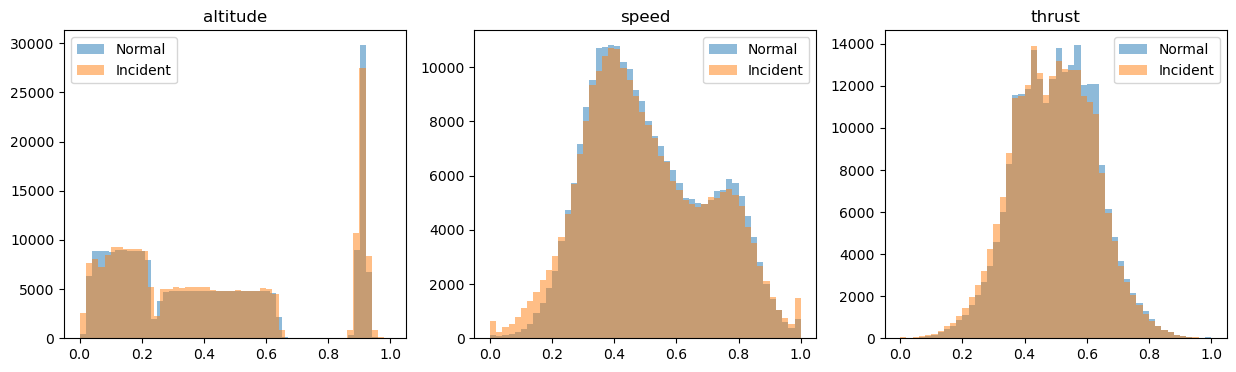

In [23]:
# Check class balance
print("Training set distribution:")
print(f"Class 0: {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"Class 1: {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")

# Verify incident features are distinct
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, feat in enumerate(['altitude', 'speed', 'thrust']):
    axes[i].hist(X_seq_train[y_train==0, :, i].flatten(), alpha=0.5, label='Normal', bins=50)
    axes[i].hist(X_seq_train[y_train==1, :, i].flatten(), alpha=0.5, label='Incident', bins=50)
    axes[i].set_title(feat)
    axes[i].legend()
plt.show()


In [ ]:
from transformer import AviationTransformer

num_features = X_seq_train.shape[2]         # Number of telemetry features per timestep
num_meta_features = X_meta_train.shape[1]   # Number of processed metadata features

model = AviationTransformer(
    num_features=num_features,
    num_meta_features=num_meta_features,
    d_model=128,            # or your preferred dimension
    nhead=8,                # match your design
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    layerdrop=0.1,
    max_seq_len=X_seq_train.shape[1]
).to(device)

In [25]:
def find_optimal_batch_size(model, device, max_batch=512):
    """
    Binary search for the largest batch size that fits in memory,
    using the model's actual metadata dimension.
    """
    # Extract metadata dimension from model
    # meta_fc is: Linear(in_features=num_meta_features, out_features=64)
    num_meta = model.meta_fc[0].in_features

    batch_size = 32
    while batch_size <= max_batch:
        try:
            # Create dummy inputs with the correct shapes
            dummy_seq  = torch.randn(batch_size, 60, 7, device=device)
            dummy_meta = torch.randn(batch_size, num_meta, device=device)

            outputs = model(dummy_seq, dummy_meta)
            loss = outputs.sum()
            loss.backward()
            return batch_size  # success

        except RuntimeError as e:
            if 'out of memory' in str(e):
                # Too large: try half
                torch.cuda.empty_cache()
                batch_size //= 2
                if batch_size == 0:
                    raise RuntimeError("Not enough GPU memory even for batch_size=1")
            else:
                # Propagate other errors
                raise e

    return batch_size


In [26]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def find_optimal_threshold(model, dataloader, device):
    """
    Runs the model on dataloader to compute predicted probabilities and
    searches for the threshold that maximizes F1 score on the validation set.
    """
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for seqs, meta, labels in dataloader:
            seqs, meta = seqs.to(device), meta.to(device)
            logits = model(seqs, meta).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    y_true = np.array(all_labels)
    y_scores = np.array(all_probs)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # Compute F1 for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    # Exclude last point where no threshold
    f1_scores = f1_scores[:-1]
    thresholds = thresholds

    # Find threshold with maximum F1
    best_idx = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Optimal threshold: {best_threshold:.3f} with F1 score: {best_f1:.3f}")
    return best_threshold

# Example usage before training loop:
# best_thresh = find_optimal_threshold(model, val_loader, device)
# Then use `best_thresh` when computing predictions in evaluation.


In [27]:
optimal_batch = find_optimal_batch_size(model, device)
print(f"Optimal batch size: {optimal_batch}")

Optimal batch size: 32


In [28]:
from torch.utils.data import WeightedRandomSampler

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(y_train), replacement=True)

In [29]:
from dataset import AviationDataset
from torch.utils.data import DataLoader

# Create datasets and dataloaders
train_dataset = AviationDataset(X_seq_train, X_meta_train, y_train)
val_dataset = AviationDataset(X_seq_val, X_meta_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=optimal_batch, sampler=sampler, 
                          num_workers=4, pin_memory=True, prefetch_factor=2, 
                          persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=optimal_batch, shuffle=False, 
                        num_workers=2, pin_memory=True, prefetch_factor=2, 
                        persistent_workers=True)

In [30]:
best_train_thresh = find_optimal_threshold(model, train_loader, device)
print(f"Best training threshold: {best_train_thresh:.4f}")

Optimal threshold: 0.469 with F1 score: 0.661
Best training threshold: 0.4693


In [31]:
best_val_thresh = find_optimal_threshold(model, val_loader, device)
print(f"Best validation threshold: {best_val_thresh:.4f}")

Optimal threshold: 0.469 with F1 score: 0.667
Best validation threshold: 0.4691


In [35]:
# Calculate class weights
from loss import FocalLoss
from collections import Counter
from torch.nn import BCEWithLogitsLoss

class_counts = Counter(y_train)
pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = FocalLoss(alpha=[0.5,0.5], gamma=2.0)

In [36]:
from torch.optim.lr_scheduler import OneCycleLR
import torch_optimizer as optim_advanced

# Ensure directory exists
os.makedirs('models', exist_ok=True)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Optimizer and OneCycleLR
optimizer = optim_advanced.Ranger(model.parameters(), lr=3e-6, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100,
)


print("\nStarting training...")
for epoch in range(num_epochs):
    # Train for one epoch (scheduling inside)
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        accumulation_steps=4,
        optimum_threshold=best_train_thresh
    )

    # Validate
    val_loss, val_acc, val_probs, val_labels = validate(model, val_loader, criterion, device, optimum_threshold=best_val_thresh)

    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Log
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        if not os.path.exists('models'):
            os.makedirs('models')
        torch.save(model.state_dict(), 'models/best_aviation_transformer.pt')
        print("  → Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break



Starting training...


c:\Users\Marc\anaconda3\envs\casenv\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1642.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 1/100
  Train Loss: 0.7139, Train Acc: 0.5030
  Val   Loss: 0.7057, Val   Acc: 0.5145
  → Model saved!
Epoch 2/100
  Train Loss: 0.7082, Train Acc: 0.5111
  Val   Loss: 0.6993, Val   Acc: 0.5350
  → Model saved!
Epoch 3/100
  Train Loss: 0.6955, Train Acc: 0.5430
  Val   Loss: 0.6770, Val   Acc: 0.6045
  → Model saved!
Epoch 4/100
  Train Loss: 0.6731, Train Acc: 0.5873
  Val   Loss: 0.6402, Val   Acc: 0.6615
  → Model saved!
Epoch 5/100
  Train Loss: 0.6287, Train Acc: 0.6344
  Val   Loss: 0.6445, Val   Acc: 0.6725
Epoch 6/100
  Train Loss: 0.6019, Train Acc: 0.6492
  Val   Loss: 0.6361, Val   Acc: 0.6740
  → Model saved!
Epoch 7/100
  Train Loss: 0.5872, Train Acc: 0.6524
  Val   Loss: 0.5711, Val   Acc: 0.6745
  → Model saved!
Epoch 8/100
  Train Loss: 0.5597, Train Acc: 0.6856
  Val   Loss: 0.4009, Val   Acc: 0.8500
  → Model saved!
Epoch 9/100
  Train Loss: 0.4175, Train Acc: 0.8174
  Val   Loss: 0.1710, Val   Acc: 0.9385
  → Model saved!
Epoch 10/100
  Train Loss: 0.2760, T

In [37]:
# Load best model
model.load_state_dict(torch.load('models/best_aviation_transformer.pt'))

C:\Users\Marc\AppData\Local\Temp\ipykernel_8204\154976086.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_aviation_transfor

<All keys matched successfully>

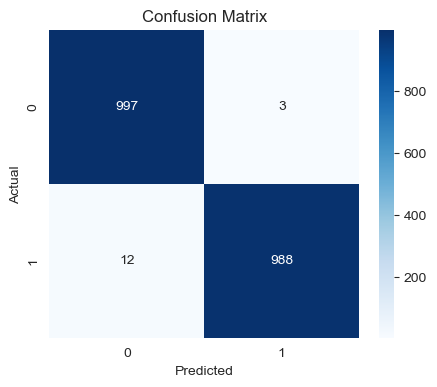

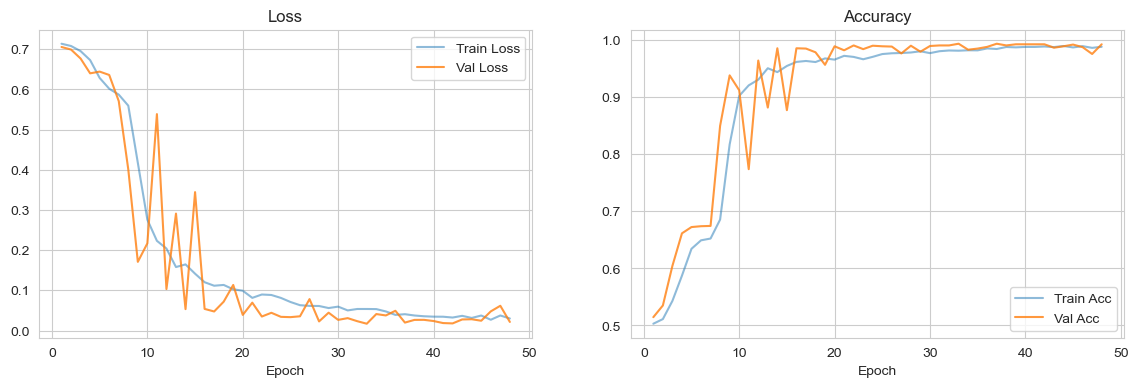

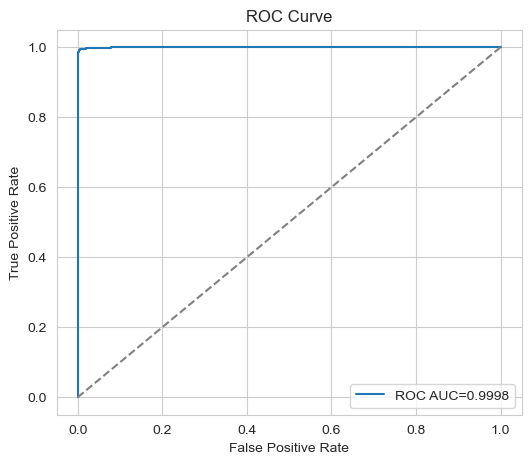

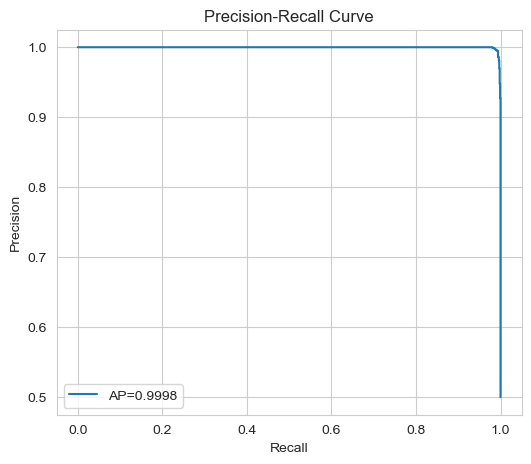

Classification report (threshold 0.479):

              precision    recall  f1-score   support

         0.0     0.9881    0.9970    0.9925      1000
         1.0     0.9970    0.9880    0.9925      1000

    accuracy                         0.9925      2000
   macro avg     0.9925    0.9925    0.9925      2000
weighted avg     0.9925    0.9925    0.9925      2000



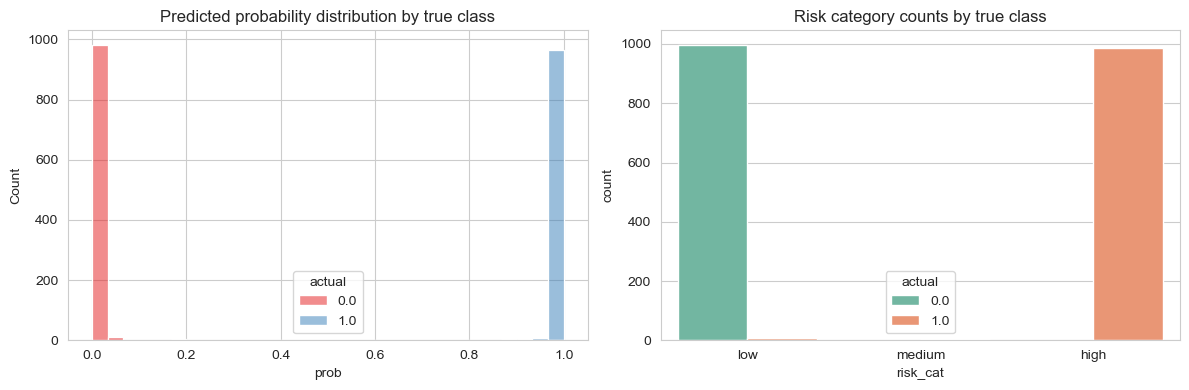

Feature importance step failed: Found input variables with inconsistent numbers of samples: [10000, 3]
Sample results (first 50 rows):


,prob,pred,actual,risk_cat,meta_cat__weather_clear,meta_cat__weather_fog,meta_cat__weather_heavy_turbulence,meta_cat__weather_light_rain,seq_f0_mean,seq_f0_std
0,0.090334,0,0.0,low,1.0,0.0,0.0,0.0,0.127539,0.059152
1,1.000000,1,1.0,high,1.0,0.0,0.0,0.0,0.911969,0.008714
2,0.000058,0,0.0,low,0.0,0.0,0.0,1.0,0.446547,0.112944
3,0.999956,1,1.0,high,0.0,0.0,1.0,0.0,0.442325,0.112671
4,0.000020,0,0.0,low,0.0,0.0,1.0,0.0,0.911317,0.011838
5,0.000192,0,0.0,low,1.0,0.0,0.0,0.0,0.127174,0.061825
6,0.000743,0,0.0,low,0.0,0.0,0.0,1.0,0.128418,0.060189
7,1.000000,1,1.0,high,1.0,0.0,0.0,0.0,0.128100,0.060500
8,0.000092,0,0.0,low,0.0,0.0,0.0,0.0,0.445206,0.111036
9,1.000000,1,1.0,high,0.0,0.0,0.0,0.0,0.122746,0.066472



Result summary:
  Samples: 2000
  Accuracy: 0.9925  Precision: 0.9970  Recall: 0.9880  F1: 0.9925
  ROC AUC: 0.9998  Average Precision (AP): 0.9998


In [38]:
import time, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, average_precision_score)
from sklearn.ensemble import RandomForestClassifier

sns.set_style("whitegrid")

# ensure we have probs/labels
try:
    vp = val_probs
    vl = val_labels
except NameError:
    print("Running validate() to obtain val_probs / val_labels (may take a moment)...")
    val_loss, val_acc, vp, vl = validate(model, val_loader, criterion, device)

# basic preds / thresholds
threshold = 0.4794
preds = (vp >= threshold).astype(int)

# 1) Confusion matrix (seaborn)
cm = confusion_matrix(vl, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# 2) Loss & Accuracy curves
try:
    tr_loss = np.array(train_losses)
    va_loss = np.array(val_losses)
    tr_acc = np.array(train_accs)
    va_acc = np.array(val_accs)
    epochs = np.arange(1, len(tr_loss)+1)
    fig, ax = plt.subplots(1,2,figsize=(14,4))
    ax[0].plot(epochs, tr_loss, label='Train Loss', alpha=0.5)
    ax[0].plot(epochs, va_loss, label='Val Loss', alpha=0.8)
    ax[0].set_title("Loss"); ax[0].set_xlabel("Epoch"); ax[0].legend()
    ax[1].plot(epochs, tr_acc, label='Train Acc', alpha=0.5)
    ax[1].plot(epochs, va_acc, label='Val Acc', alpha=0.8)
    ax[1].set_title("Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].legend()
    plt.show()
except Exception as e:
    print("Train/val history not available:", e)

# 3) ROC curve
fpr, tpr, _ = roc_curve(vl, vp)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend()
plt.show()

# 4) Precision-Recall curve
prec, rec, pr_thr = precision_recall_curve(vl, vp)
ap = average_precision_score(vl, vp)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()

# 5) Classification report
print("Classification report (threshold {:.3f}):\n".format(threshold))
print(classification_report(vl, preds, digits=4))

# 6) Risk distribution graph (prob histogram + buckets)
df_res = pd.DataFrame({"prob": vp.flatten(), "actual": vl.flatten(), "pred": preds.flatten()})
bins = [0.0, 0.33, 0.66, 1.0]
labels = ["low","medium","high"]
df_res["risk_cat"] = pd.cut(df_res["prob"], bins=bins, labels=labels, include_lowest=True)
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.histplot(data=df_res, x="prob", hue="actual", bins=30, kde=False, ax=ax[0], palette="Set1")
ax[0].set_title("Predicted probability distribution by true class")
sns.countplot(data=df_res, x="risk_cat", hue="actual", ax=ax[1], palette="Set2")
ax[1].set_title("Risk category counts by true class")
plt.tight_layout(); plt.show()

# 7) Feature importance (metadata + aggregated sequence features)
# Build aggregated sequence features (mean, std, min, max per original feature) for validation+training to fit a small RF
def aggregate_seqs(seqs_array):
    # seqs_array: (N, T, F)
    means = seqs_array.mean(axis=1)
    stds = seqs_array.std(axis=1)
    mins = seqs_array.min(axis=1)
    maxs = seqs_array.max(axis=1)
    # flatten with suffixes
    cols = []
    agg = np.concatenate([means, stds, mins, maxs], axis=1)
    return agg


try:
    # aggregate sequence features
    X_seq_agg = aggregate_seqs(sequences_norm)  # (N, 4*F)

    # include processed meta if available and convert sparse -> dense
    X_meta_full = X_meta_processed if 'X_meta_processed' in globals() else None
    if X_meta_full is not None and hasattr(X_meta_full, "toarray"):
        try:
            X_meta_full = X_meta_full.toarray()
        except Exception:
            X_meta_full = np.asarray(X_meta_full)

    # build full feature matrix and names
    F = sequences_norm.shape[2]
    seq_names = [f"f{i}{stat}" for stat in ["_mean","_std","_min","_max"] for i in range(F)]

    if X_meta_full is not None:
        X_full = np.hstack([X_seq_agg, X_meta_full])
        # meta feature names (robust to different sklearn versions)
        try:
            if hasattr(preprocessor, "get_feature_names_out"):
                meta_names = list(preprocessor.get_feature_names_out())
            elif hasattr(preprocessor, "get_feature_names"):
                meta_names = list(preprocessor.get_feature_names())
            else:
                meta_names = [f"meta_{i}" for i in range(X_meta_full.shape[1])]
        except Exception:
            meta_names = [f"meta_{i}" for i in range(X_meta_full.shape[1])]
        feat_names = seq_names + meta_names
    else:
        X_full = X_seq_agg
        feat_names = seq_names

    # robust y construction
    if 'labels' in globals():
        y_full = labels
    elif 'y_train' in globals() and 'y_val' in globals():
        y_full = np.concatenate([y_train, y_val])
    elif 'y_train' in globals():
        y_full = y_train
    else:
        y_full = None

    # verify shapes and fix names length if mismatch
    if X_full is not None and y_full is not None:
        if X_full.shape[1] != len(feat_names):
            # pad or trim names to match feature matrix
            diff = X_full.shape[1] - len(feat_names)
            if diff > 0:
                feat_names += [f"feat_extra_{i}" for i in range(diff)]
            else:
                feat_names = feat_names[: X_full.shape[1]]

        # check that y contains at least two classes
        if len(np.unique(y_full)) < 2:
            print("Cannot fit feature-importance model: target has a single class.")
        else:
            rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
            rf.fit(X_full, y_full)
            importances = rf.feature_importances_
            imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
            imp_df = imp_df.sort_values("importance", ascending=False).head(30)

            plt.figure(figsize=(6, 10))
            sns.barplot(x="importance", y="feature", data=imp_df, palette="viridis")
            plt.title("Top feature importances (RandomForest on aggregated features)")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()
    else:
        print("Not enough data to compute feature importance (missing X or y).")
except Exception as e:
    print("Feature importance step failed:", e)

# 8) Table of actual, predicted, prob, risk plus some meta/agg columns (show first 50)
try:
    # if X_meta_val exists (processed), convert to DataFrame for display
    if 'X_meta_val' in globals():
        meta_display = pd.DataFrame(X_meta_val if not hasattr(X_meta_val, "toarray") else X_meta_val, 
                                    columns=(preprocessor.get_feature_names_out() if hasattr(preprocessor, "get_feature_names_out") else None))
    else:
        meta_display = None

    seq_agg_val = aggregate_seqs(X_seq_val) if 'X_seq_val' in globals() else None
    table = df_res.copy()
    if meta_display is not None:
        # add a few meta cols if available
        for i, col in enumerate(meta_display.columns[:4]):
            table[f"meta_{col}"] = meta_display.iloc[:, i].values
    if seq_agg_val is not None:
        # add first two aggregated seq features for quick glance
        table["seq_f0_mean"] = seq_agg_val[:, 0]
        table["seq_f0_std"] = seq_agg_val[:, seq_agg_val.shape[1]//4]  # approx std column
    display_cols = ["prob","pred","actual","risk_cat"] + [c for c in table.columns if c.startswith("meta_")][:4] + ["seq_f0_mean","seq_f0_std"]
    display_table = table[display_cols].head(50)
    print("Sample results (first 50 rows):")
    display(display_table)
except Exception as e:
    print("Could not build result table:", e)

# 9) Result summary (numbers)
acc = accuracy_score(vl, preds)
prec = precision_score(vl, preds, zero_division=0)
rec = recall_score(vl, preds, zero_division=0)
f1 = f1_score(vl, preds, zero_division=0)
roc = roc_auc_score(vl, vp)
ap = average_precision_score(vl, vp)
print("\nResult summary:")
print(f"  Samples: {len(vl)}")
print(f"  Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print(f"  ROC AUC: {roc:.4f}  Average Precision (AP): {ap:.4f}")